## Config

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [10]:
from numpy import outer, eye, ones, zeros, diag, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln
from scipy.stats import norm

import numpy as np

import matplotlib.pyplot as plt
from numpy import arange, min, max, sqrt, mean, std
from scipy.spatial.distance import cosine
import numpy as np

## EM-algorithm

In [11]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

import copy

class EM_algo():
    """
        A superclass for different EM-fitted models.
    """

    def __init__(self, hyperparams, X=None, Y=None, ndata=0, pdata=0):
        """
            Initialize model based either on given data (X, Y) or
            on given data dimensionality (ndata, pdata).
        """
        if not X is None and not Y is None:
            self.X = X
            self.Y = Y
            self.ndata = len(self.X)
            self.pdata = len(self.X[0])
        if ndata and pdata:
            self.X = None
            self.Y = None
            self.ndata = ndata
            self.pdata = pdata
        self.h = hyperparams
        self.p = dict() # model parameters
        self.reset()
        if not X is None and not Y is None:
            self.current_logl, self.cll = self.logl()


    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        raise NotImplementedError("Subclass implements")


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the drawn y and z-values.
        """
        raise NotImplementedError("Subclass implements")


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        raise NotImplementedError("Subclass implements")


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.
        """
        raise NotImplementedError("Subclass implements")


    def EM_fit(self, alim=1e-10, maxit=1e4):
        """
            Calls the EM_iter repeatedly until the log likelihood
            of the model increases less than 'alim' in absolute
            value or after 'maxit' iterations have been done.

            Returns the number of EM-iterations, final log likelihood
            value and a string that explains the end condition.
        """
        logl, ll = self.logl()
        for i in range(int(maxit)):
            self.EM_iter()
            logl2, ll2 = self.logl()
            adiff = abs(logl2 - logl)
            if adiff < alim:
                return i+1, logl2, "alim"
            logl = logl2
        return maxit, logl2, "maxit"


    def assert_logl_increased(self, event):
        """
            Checks that the log likelihood increased since model
            initialization or the time this function was last called.
        """
        newlogl, ll = self.logl()
        if self.current_logl - newlogl > 1e-3:
            self.debug_logl(self.cll, ll)
            raise ValueError("logl decreased after %s" % (event))
        self.current_logl, self.cll = newlogl, ll


    def get_p(self):
        """
            Returns a copy of the model parameters.
        """
        return copy.deepcopy(self.p)


    def set_p(self, p):
        """
            Sets the model parameters.
        """
        self.p = p.copy()


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        for k, v in self.p.items():
            print("%s = %s" % (k, v))


    def pretty_vector(self, x):
        """
            Returns a formatted version of a vector.
        """
        s = ["("]
        s.extend(["%.2f, " % (xi) for xi in x[:-1]])
        s.append("%.2f)" % (x[-1]))
        return "".join(s)


    def debug_logl(self, ll1, ll2):
        """
            Prints an analysis of the per-term change in
            log likelihood from ll1 to ll2.
        """
        print("Logl      before     after")
        for v1, v2, i in zip(ll1, ll2, range(len(ll1))):
            if v1 > v2:
                d = ">"
            elif v2 > v1:
                d = "<"
            else:
                d = "="
            print("Term %02d: %7.3f %s %7.3f" % (i, v1, d, v2))
        print("Total    %7.3f   %7.3f" % (sum(ll1), sum(ll2)))



## Linear model

In [12]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

from numpy import outer, eye, ones, zeros, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln

class EM_algo_LM(EM_algo):
    """
        A linear gaussian model.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]

        # initial parameter estimates drawn from prior
        self.p           = dict()
        self.p["sigma2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi"]    = mvnormal(self.mu_phi0, self.p["sigma2"] * self.sigma_phi0)


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value (and a constant z-value for compatibility)
        """
        mean = float(item.dot(self.p["phi"]))
        std  = sqrt(self.p["sigma2"])
        return normal(mean, std), 1


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll    = zeros(8)
        phie  = self.p["phi"] - self.mu_phi0
        err   = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        # p(y)
        ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * self.ndata
        ll[1] = sum(- 0.5 * err / self.p["sigma2"])
        # p(phi)
        ll[2] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2"]) * self.pdata
        ll[3] = - 0.5 * phie.T.dot(phie) / (self.lbd_phi0 * self.p["sigma2"])
        # p(sigma2)
        ll[4] = self.alpha_s20 * log(self.beta_s20)
        ll[5] = - gammaln(self.alpha_s20)
        ll[6] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2"])
        ll[7] = - self.beta_s20 / self.p["sigma2"]
        return sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        # phi
        sumxx         = self.X.T.dot(self.X)
        sumxy         = self.X.T.dot(self.Y)
        sigma_mu      = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv = self.sigma_phi0_inv + sumxx
        self.p["phi"] = solve(sigma_phi_inv, sigma_mu + sumxy)
        self.assert_logl_increased("phi update")

        # sigma2
        phie = (self.p["phi"] - self.mu_phi0) ** 2
        err  = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        num  = self.beta_s20 + 0.5 * sum(err) + 0.5 * sum(phie) / self.lbd_phi0
        den  = self.alpha_s20 + 1.0 + 0.5 * (self.ndata + self.pdata)
        self.p["sigma2"] = num / den
        if self.p["sigma2"] < 0.0:
            raise ValueError("sigma2 < 0.0")
        self.assert_logl_increased("sigma2 update")


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        print("phi    : %s" % (self.pretty_vector(self.p["phi"])))
        print("sigma2 : %.3f" % (self.p["sigma2"]))



## Generator

In [13]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

from numpy import zeros
from numpy.random import randn


def generate_X(ndata, pdata):
    """
        Return a matrix of normally distributed random values.
    """
    X = randn(ndata, pdata)
    return X


def generate_YZ(X, distribution):
    """
        Draw observations Y and latent variable values Z from a distribution.
    """
    ndata = len(X)
    Y = zeros(ndata)
    Z = zeros(ndata)
    for i in range(ndata):
        Y[i], Z[i] = distribution.draw(X[i])
    return Y, Z


def get_hyperp():
    """
        Return model hyperparameters.
    """
    return {
            "alpha_s20": 5.0,
            "beta_s20" : 1.0,
            "lbd_phi0" : 1.0,
            "mu_phi0"  : 0.0,
            "alpha_w0" : 3.0,
            "beta_w0"  : 3.0,
            }


## Mixture model

Note that for responsibilities 
$$\gamma_1 =  \frac{ w_S \mathcal{N}(y_t \ | \ x_t \phi_{1_S}, \sigma_{1_S}^2)}{ w_S \mathcal{N}(y_t \ | \ x_t \phi_{1_S} , \sigma_{1_S}^2) \; + \; (1 - w_S) \mathcal{N}(y_t \ | \ x_t \phi_{2_S}, \sigma_{2_S}^2)} $$
$$\gamma_2 =  \frac{ (1 - w_S) \mathcal{N}(y_t \ | \ x_t \phi_{2_S}, \sigma_{2_S}^2)}{ w_S \mathcal{N}(y_t \ | \ x_t \phi_{1_S} , \sigma_{1_S}^2) \; + \; (1 - w_S) \mathcal{N}(y_t \ | \ x_t \phi_{2_S}, \sigma_{2_S}^2)} $$

If we only need to know whether $\gamma_1 > \gamma_2$, then we need to only compute

$$ w_S \mathcal{N}(y_t \ | \ x_t \phi_{1_S}, \sigma_{1_S}^2) > (1 - w_S) \mathcal{N}(y_t \ | \ x_t \phi_{2_S}, \sigma_{2_S}^2)$$

In [60]:
from numpy import outer, eye, ones, zeros, diag, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln
from scipy.stats import norm, multivariate_normal
import numpy as np

class EM_algo_MM(EM_algo):
    """
        A mixture of two linear models.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.alpha_w0       = self.h["alpha_w0"]
        self.beta_w0        = self.h["beta_w0"]

        # Same priors for phi1 and phi2, s2_1, s2_2, don't bother to copy vars twice
        # i.e. alpha_s2_1_0 = alpha_s2_2_0 = alpha_s20
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]
        
        # Precalculations:
        self.w_gamma_ln_multiplier  = gammaln(self.alpha_w0 + self.beta_w0)
        self.w_gamma_ln_multiplier -= gammaln(self.alpha_w0)
        self.w_gamma_ln_multiplier -= gammaln(self.beta_w0)
        
        
        # initial parameter estimates drawn from prior
        self.p             = dict()
        # Weights
        self.p["w"]        = beta(self.alpha_w0, self.beta_w0)
        # Responsibilities (TODO: do we need this here?)
        self.p["gamma"]    = binomial(1, self.p["w"], self.ndata)
        # Component 1
        self.p["sigma2_1"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_1"]    = mvnormal(self.mu_phi0, self.p["sigma2_1"] * self.sigma_phi0)
        # Component 2
        self.p["sigma2_2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_2"]    = mvnormal(self.mu_phi0, self.p["sigma2_2"] * self.sigma_phi0)
        
        print("START w", self.p["w"])
        print("START phi_1", self.p["phi_1"])
        print("START sigma2_1", self.p["sigma2_1"])
        print("START phi_2", self.p["phi_2"])
        print("START sigma2_2", self.p["sigma2_2"])


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value and z-value
        """
        mean1 = float(item.dot(self.p["phi_1"]))
        std1  = sqrt(self.p["sigma2_1"])
        mean2 = float(item.dot(self.p["phi_2"]))
        std2  = sqrt(self.p["sigma2_2"])
        
#         print("mean1", mean1, "std1", std1, "mean2", mean2, "std2", std2)
        
#         print("X shape", X.shape)
        
        # Responsibilites for item (item is a data point)
#         print("prob1", multivariate_normal.pdf(item, mean=mean1, cov=std1))
#         print("prob2", multivariate_normal.pdf(item, mean=mean2, cov=std2))
#         propto_gamma1 =      self.p["w"]  * multivariate_normal.pdf(item, mean=mean1, cov=std1)
#         propto_gamma2 = (1 - self.p["w"]) * multivariate_normal.pdf(item, mean=mean2, cov=std2)
        propto_gamma1 =      self.p["w"]  * norm.pdf(item.dot(self.p["phi_1"]), mean1, std1)
        propto_gamma2 = (1 - self.p["w"]) * norm.pdf(item.dot(self.p["phi_2"]), mean2, std2) # IS THIS CORRECT??? item dot phi
#         print("propto_gamma1", propto_gamma1)
#         print("propto_gamma2", propto_gamma2)
        
        if (propto_gamma1 > propto_gamma2):
#             return mvnormal(mean1, std1), 1
            return normal(mean1, std1), 1
        else:
#             return mvnormal(mean2, std2), 2
            return normal(mean2, std2), 2


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll         = zeros(20)
        phi_1_diff = self.p["phi_1"] - self.mu_phi0
        phi_2_diff = self.p["phi_2"] - self.mu_phi0
        phi_1_err  = phi_1_diff.T.dot(phi_1_diff)
        phi_2_err  = phi_2_diff.T.dot(phi_2_diff)
        err_1      = (self.X.dot(self.p["phi_1"]) - Y) ** 2
        err_2      = (self.X.dot(self.p["phi_2"]) - Y) ** 2
        
        
        # Responsibilities
#         mean1 = float(item.dot(self.p["phi_1"]))
#         std1  = sqrt(self.p["sigma2_1"])
#         mean2 = float(item.dot(self.p["phi_2"]))
#         std2  = sqrt(self.p["sigma2_2"])
#         # data is 1 dimensional, and norm.pdf works on a vector returning probability for each separately
#         propto_gamma1 = self.p["w"] * norm.pdf(self.X, mean1, std1)
#         propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.X, mean2, std2)
#         # elementwise, works because numpy
#         gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
        gamma = self.p["gamma"]
        
        ### posterior factorizes p(y,z,w,phi,sigma) = p(y)p(z)p(w)p(phi)p(sigma)
        
        ### p(y)
#         ll[0] = self.p["w"]       * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] = self.p["w"]       * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = (1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = (1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])

#         ll[0] = gamma.dot(-0.5 * log(2 * pi * self.p["sigma2_1"]) -0.5 * err_1 / self.p["sigma2_1"])
#         ll[1] = 0
#         ll[2] = (1 - gamma).dot(-0.5 * log(2 * pi * self.p["sigma2_2"]) -0.5 * err_2 / self.p["sigma2_2"])
#         ll[3] = 0

        ll[0] = -0.5 * log(2 * pi * self.p["sigma2_1"]) * np.sum(gamma)
        ll[1] = gamma.dot(-0.5 * err_1 / self.p["sigma2_1"])
        ll[2] = -0.5 * log(2 * pi * self.p["sigma2_2"]) * np.sum(1 - gamma)
        ll[3] = (1 - gamma).dot(-0.5 * err_2 / self.p["sigma2_2"])
 
        
        ### p(z)
        ll[4] = np.sum((gamma * log(self.p["w"])) + ((1 - gamma) * log(1 - self.p["w"])))
#         ll[4] = 0
        
        ### p(w)
        ll[5] = self.w_gamma_ln_multiplier
        ll[6] = (self.alpha_w0 - 1) * self.p["w"]
        ll[7] = (self.beta_w0  - 1) * (1 - self.p["w"])
        
        ### p(phi)
        # phi_1
        ll[8]  = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_1"]) * self.pdata
        ll[9]  = - 0.5 * phi_1_err / (self.lbd_phi0 * self.p["sigma2_1"])
        # phi_2
        ll[10] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_2"]) * self.pdata
        ll[11] = - 0.5 * phi_2_err / (self.lbd_phi0 * self.p["sigma2_2"])
        
        ### p(sigma2)
        # sigma2_1
        ll[12] = self.alpha_s20 * log(self.beta_s20)
        ll[13] = - gammaln(self.alpha_s20)
        ll[14] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_1"])
        ll[15] = - self.beta_s20 / self.p["sigma2_1"]
        # sigma2_2
        ll[16] = self.alpha_s20 * log(self.beta_s20)
        ll[17] = - gammaln(self.alpha_s20)
        ll[18] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_2"])
        ll[19] = - self.beta_s20 / self.p["sigma2_2"]
        
        return np.sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        
        Y = self.Y.view()
        # set Y view shape
        Y.shape = (self.ndata, 1)
        
        # TODO REMOVE
        # if possible, plot samples, true model and estimated model
        if self.pdata == 1:
            plt.figure(figsize=(20,10))
            plt.scatter(self.X, self.Y, s=20, c='black', label="Training data")
    #         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
            x = arange(min(self.X)-0.1, max(self.X)+0.1, 0.1)
    #         print_linear_model(x, true_model.get_p()["phi"], \
    #                 true_model.get_p()["sigma2"], 'red', "True model")
    #         print_linear_model(x, model.get_p()["phi"], \
    #                 model.get_p()["sigma2"], 'blue', "Predicted model")
            y = self.p["phi_1"] * x
            color = 'red'
            plt.plot(x, y, color, label="component1")
            plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_1"]), y - 1.96 * sqrt(self.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)
            
            y = self.p["phi_2"] * x
            color = 'blue'
            plt.plot(x, y, color, label="component2")
            plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_2"]), y - 1.96 * sqrt(self.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

            plt.legend(loc=1)
            plt.xlim(min(x), max(x))
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()
            input("Press Enter to continue...")

        # ==================== E-STEP ====================

        # ========== Responsibilities gamma ==========
        mean1 = np.mean(self.X.dot(self.p["phi_1"]))
        std1  = sqrt(self.p["sigma2_1"])
        mean2 = np.mean(self.X.dot(self.p["phi_2"]))
        std2  = sqrt(self.p["sigma2_2"])
        print("mean1", mean1, "std1", std1, "mean2", mean2, "std2", std2)
        
        # data is 1 dimensional, and norm.pdf works on a vector returning probability for each separately
#         propto_gamma1 =      self.p["w"]  * norm.pdf(self.X.dot(self.p["phi_1"]), mean1, std1)
#         propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.X.dot(self.p["phi_2"]), mean2, std2)
        propto_gamma1 =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), std1)
        propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), std2)
        
        # elementwise, works because numpy
        gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
        self.p["gamma"] = gamma
        sum_gamma = np.sum(gamma)
        print("sum gamma", sum_gamma, "sum gamma+(1-gamma)", np.sum(gamma+(1-gamma)))
        

        # ==================== M-STEP ====================

        # ========== Weights w ==========
        num = sum_gamma + self.alpha_w0 - 1
        den = self.ndata + self.alpha_w0 + self.beta_w0 - 2
        print("w num", num, "den", den)
        self.p["w"] = num / den
        print("w", self.p["w"])
        
        print("W LL DEBUG")
        newlogl, ll = self.logl()
        self.debug_logl(self.cll, ll)
#         self.assert_logl_increased("w update")
        
        
        # ========== Variables phi ==========
        
        # phi_1
        
#         sum_gammaxx   = sum(np.multiply(gamma, np.multiply(self.X, self.X)))
#         sum_gammaxy   = sum(np.multiply(gamma, np.multiply(self.X, self.Y)))
#         sum_gammaxx   = np.dot(gamma, np.multiply(self.X, self.X))

#         print("Y SHAPE", Y.shape)
#         print("X SHAPE", self.X.shape)
#         tsup = Y * self.X
#         print("tsup SHAPE", tsup.shape)
        
#         print("gamma shape", gamma.shape)
#         print("gamma.T shape", gamma.T.shape)

        sum_gammayx = gamma.T.dot(Y * self.X)
        sum_gammaxx = gamma.T.dot((self.X * self.X))
        
#         print("sum_gammayx, sum_gammaxx SHAPES", sum_gammayx.shape, sum_gammaxx.shape)
        
        sigma_mu        = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv   = self.sigma_phi0_inv + sum_gammaxx
        self.p["phi_1"] = solve(sigma_phi_inv, sigma_mu + sum_gammayx)
        print("phi_1", self.p["phi_1"])
        
        
        # phi_2
        sum_gammayx = (1-gamma).T.dot(Y * self.X)
        sum_gammaxx = (1-gamma).T.dot((self.X * self.X))
        
#         print("sum_gammayx, sum_gammaxx SHAPES", sum_gammayx.shape, sum_gammaxx.shape)
        
        sigma_mu        = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv   = self.sigma_phi0_inv + sum_gammaxx
        self.p["phi_2"] = solve(sigma_phi_inv, sigma_mu + sum_gammayx)
        print("phi_2", self.p["phi_2"])
        
        print("PHI LL DEBUG")
        newlogl, ll = self.logl()
        self.debug_logl(self.cll, ll)
#         self.assert_logl_increased("phi update")


        # ========== Variances sigma2 ==========
        
        # sigma2_1
        phie = np.sum((self.p["phi_1"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        print('phie', phie)
        err  = (Y - self.X.dot(self.p["phi_1"])) ** 2
        print('sum gamma*err', np.sum(gamma * err))
        num = 2*self.beta_s20 + np.sum(gamma * err) + phie
        den = 2*self.alpha_s20 + 2.0 + np.sum(gamma) + self.pdata
        self.p["sigma2_1"] = num / den
        print('sigma2_1', self.p["sigma2_1"])
        if self.p["sigma2_1"] < 0.0:
            raise ValueError("sigma2_1 < 0.0")
        
        # sigma2_2
        phie = np.sum((self.p["phi_2"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        print('phie', phie)
        err  = (Y - self.X.dot(self.p["phi_2"])) ** 2
        print('sum (1-gamma)*err', np.sum((1-gamma) * err))
#         print('sum gamma*err', np.sum(gamma * err))
        num = 2*self.beta_s20 + np.sum((1-gamma) * err) + phie
        den = 2*self.alpha_s20 + 2.0 + np.sum(1-gamma) + self.pdata
        self.p["sigma2_2"] = num / den
        print('sigma2_2', self.p["sigma2_2"])
        if self.p["sigma2_2"] < 0.0:
            raise ValueError("sigma2_2 < 0.0")
        
        print("SIGMA LL DEBUG")
        newlogl, ll = self.logl()
        self.debug_logl(self.cll, ll)
        
        # if possible, plot samples, true model and estimated model
        if self.pdata == 1:
            plt.figure(figsize=(20,10))
            plt.scatter(self.X, self.Y, s=20, c='black', label="Training data")
    #         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
            x = arange(min(self.X)-0.1, max(self.X)+0.1, 0.1)
    #         print_linear_model(x, true_model.get_p()["phi"], \
    #                 true_model.get_p()["sigma2"], 'red', "True model")
    #         print_linear_model(x, model.get_p()["phi"], \
    #                 model.get_p()["sigma2"], 'blue', "Predicted model")
            y = self.p["phi_1"] * x
            color = 'red'
            plt.plot(x, y, color, label="component1")
            plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_1"]), y - 1.96 * sqrt(self.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)
            
            y = self.p["phi_2"] * x
            color = 'blue'
            plt.plot(x, y, color, label="component2")
            plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_2"]), y - 1.96 * sqrt(self.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

            plt.legend(loc=1)
            plt.xlim(min(x), max(x))
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()
            input("Press Enter to continue...")
        
        self.assert_logl_increased("sigma2 update")


In [61]:
# get hyperparameters for model
hyperp = get_hyperp()
# generate 50 training data and 20 validation data locations of dim=1
ndata = 50
ndata_v = 50
pdata = 1
X = generate_X(ndata, pdata)
X_v = generate_X(ndata_v, pdata)

true_model = EM_algo_MM(hyperp, ndata=ndata, pdata=pdata)
Y, Z = generate_YZ(X, true_model)
Y_v, Z_v = generate_YZ(X_v, true_model)
print("Generated %d training data and %d validation data from true model:" % \
    (ndata, ndata_v))
true_model.print_p()
print("")

START w 0.37592919331116076
START phi_1 [-0.56743819]
START sigma2_1 0.29868671334772023
START phi_2 [ 0.08343536]
START sigma2_2 0.18034113836796606
Generated 50 training data and 50 validation data from true model:
w = 0.37592919331116076
sigma2_1 = 0.29868671334772023
gamma = [0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1
 0 0 1 1 1 1 1 1 0 1 0 1 0]
phi_2 = [ 0.08343536]
phi_1 = [-0.56743819]
sigma2_2 = 0.18034113836796606



START w 0.2150171346185789
START phi_1 [ 0.37235774]
START sigma2_1 0.23661816856853746
START phi_2 [ 0.14983351]
START sigma2_2 0.27986017625824844


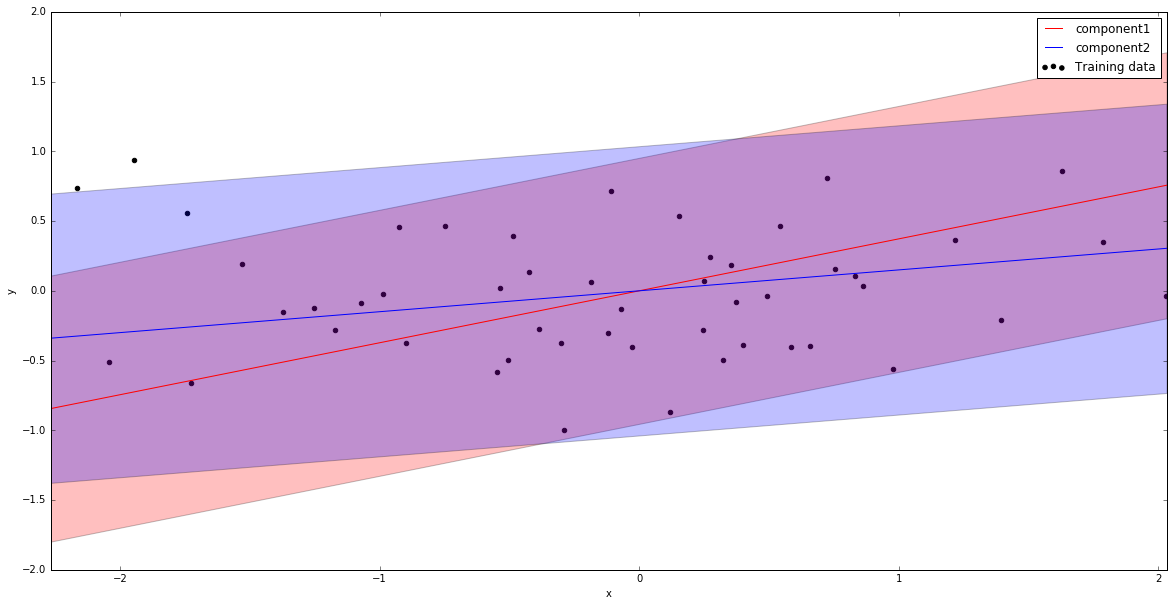

Press Enter to continue...
mean1 -0.0492150534472 std1 0.4864341359 mean2 -0.0198037088417 std2 0.529018124697
sum gamma 9.79063870275 sum gamma+(1-gamma) 50.0
w num 11.7906387028 den 54.0
w 0.218345161162
W LL DEBUG
Logl      before     after
Term 00:  -2.776 <  -1.941
Term 01:  -6.055 <  -3.928
Term 02: -10.159 > -11.347
Term 03: -16.055 > -16.993
Term 04: -30.234 < -24.803
Term 05:   3.401 =   3.401
Term 06:   0.430 <   0.437
Term 07:   1.570 >   1.563
Term 08:  -0.198 =  -0.198
Term 09:  -0.293 =  -0.293
Term 10:  -0.282 =  -0.282
Term 11:  -0.040 =  -0.040
Term 12:   0.000 =   0.000
Term 13:  -3.178 =  -3.178
Term 14:   8.648 =   8.648
Term 15:  -4.226 =  -4.226
Term 16:   0.000 =   0.000
Term 17:  -3.178 =  -3.178
Term 18:   7.641 =   7.641
Term 19:  -3.573 =  -3.573
Total    -58.558   -52.293
phi_1 [ 0.17114416]
phi_2 [-0.02471815]
PHI LL DEBUG
Logl      before     after
Term 00:  -2.776 <  -1.941
Term 01:  -6.055 <  -3.394
Term 02: -10.159 > -11.347
Term 03: -16.055 < -14.644
T

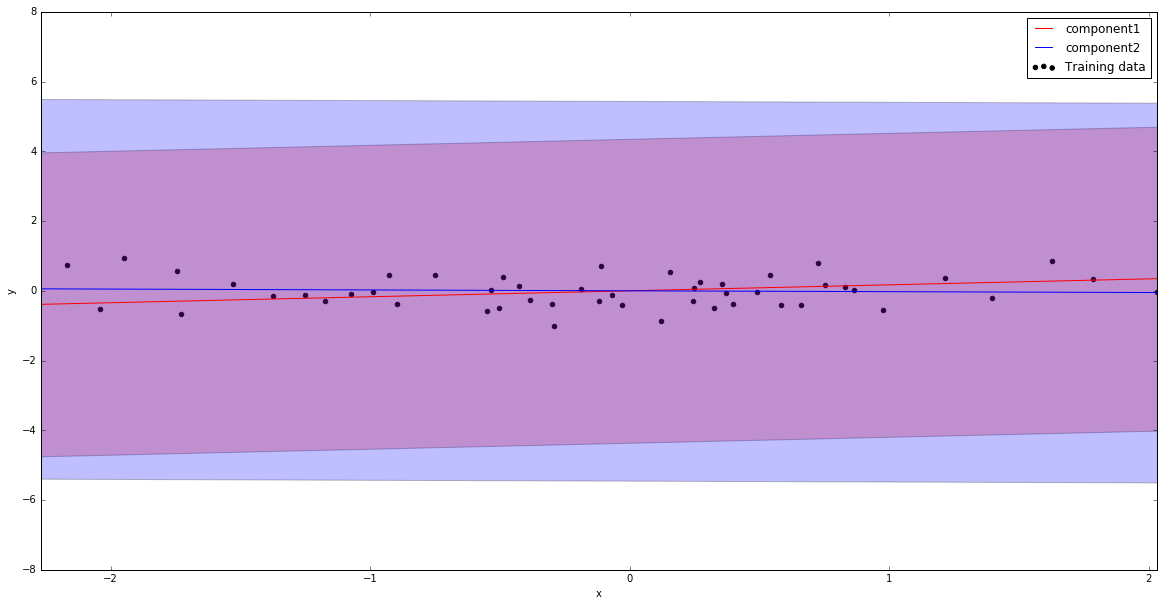

In [ ]:
# generate a model for estimating the parameters of the
# true model based on the observations (X, Y) we just made
model = EM_algo_MM(hyperp, X, Y)
i, logl, r = model.EM_fit()
print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
        (logl, i, r))
print("")
print("MAP estimate of true model parameters:")
model.print_p()
print("")

## Main

Starting program

Generated 50 training data and 50 validation data from true model:
phi    : (0.06)
sigma2 : 0.307

Model fit (logl -26.01) after 2 iterations (alim reached)

MAP estimate of true model parameters:
phi    : (0.21)
sigma2 : 0.172

Crossvalidated logl: -42.17


/Users/kuuranne/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/kuuranne/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


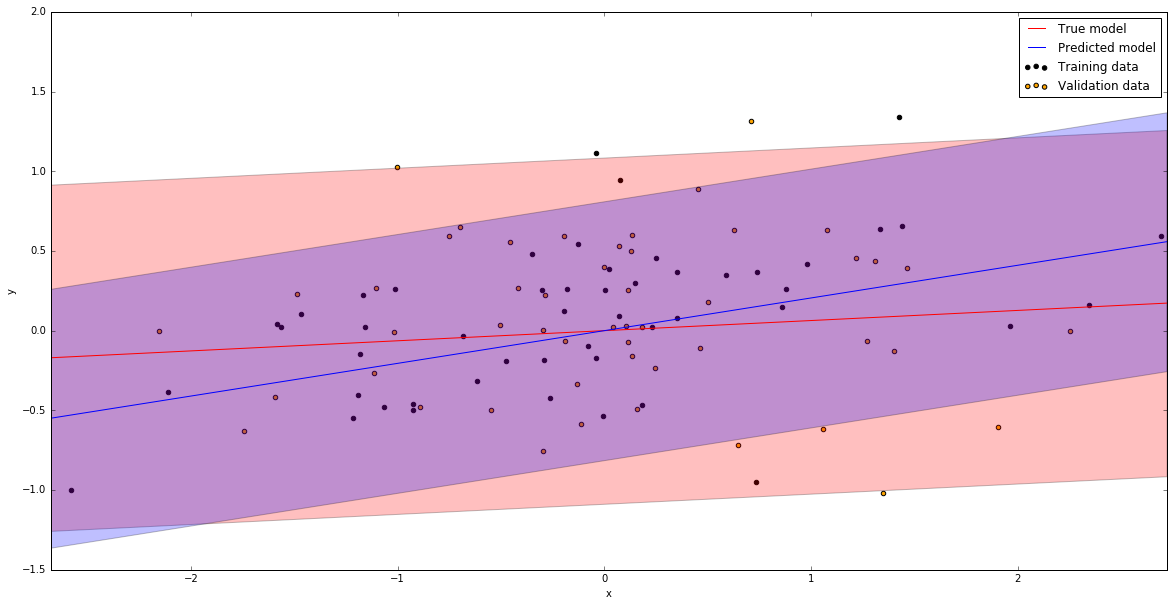

In [52]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

import matplotlib.pyplot as plt
from numpy import arange, min, max, sqrt, mean, std
from scipy.spatial.distance import cosine
import numpy as np

def main():
    """
        Executed when program is run.
    """
    print("Starting program")
    print("")
    test_LM_model()


def test_LM_model():
    """
        Example that demonstrates how to call the model.
    """
    # get hyperparameters for model
    hyperp = get_hyperp()
    # generate 50 training data and 20 validation data locations of dim=1
    ndata = 50
    ndata_v = 50
    pdata = 1
    X = generate_X(ndata, pdata)
    X_v = generate_X(ndata_v, pdata)
    # intialize true model randomly and draw observations from it
    true_model = EM_algo_LM(hyperp, ndata=ndata, pdata=pdata)
    Y, Z = generate_YZ(X, true_model)
    Y_v, Z_v = generate_YZ(X_v, true_model)
    print("Generated %d training data and %d validation data from true model:" % \
            (ndata, ndata_v))
    true_model.print_p()
    print("")

    # generate a model for estimating the parameters of the
    # true model based on the observations (X, Y) we just made
    model = EM_algo_LM(hyperp, X, Y)
    i, logl, r = model.EM_fit()
    print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
            (logl, i, r))
    print("")
    print("MAP estimate of true model parameters:")
    model.print_p()
    print("")

    # crossvalidate the estimated model with the validation data
    fit_params = model.get_p()
    model_v = EM_algo_LM(hyperp, X_v, Y_v)
    model_v.set_p(fit_params)
    logl, ll = model_v.logl()
    print("Crossvalidated logl: %.2f" % (logl))

    # if possible, plot samples, true model and estimated model
    if pdata != 1:
        return
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, s=20, c='black', label="Training data")
    plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
    print_linear_model(x, true_model.get_p()["phi"], \
            true_model.get_p()["sigma2"], 'red', "True model")
    print_linear_model(x, model.get_p()["phi"], \
            model.get_p()["sigma2"], 'blue', "Predicted model")
    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    


def print_linear_model(x, phi, sigma2, color, label):
    """
        Print linear model mean and 95% confidence interval.
    """
    y = phi * x
    plt.plot(x, y, color, label=label)
    plt.fill_between(x, y + 1.96 * sqrt(sigma2), y - 1.96 * sqrt(sigma2), \
            alpha=0.25, facecolor=color, interpolate=True)


if __name__ == "__main__":
    main()



In [286]:
X = generate_X(10, 2)

In [287]:
X.shape

(10, 2)

In [288]:
X

array([[-0.91954461,  0.2400352 ],
       [ 2.33650195,  1.81126434],
       [-0.08133542,  0.06118832],
       [-1.33545433, -0.86719239],
       [ 1.66719011, -0.57531528],
       [-0.30577782,  0.06323988],
       [ 0.99608716, -0.33705257],
       [-0.65754579, -0.1670884 ],
       [ 1.05556896,  0.3179948 ],
       [ 1.17714858,  1.69832692]])

In [289]:
X[8,:]

array([ 1.05556896,  0.3179948 ])

In [290]:
norm.pdf(X, 0, 1)

array([[ 0.26139576,  0.38761334],
       [ 0.0260286 ,  0.07736059],
       [ 0.39762487,  0.39819616],
       [ 0.16354654,  0.2739116 ],
       [ 0.09939038,  0.33809364],
       [ 0.38072096,  0.39814534],
       [ 0.24291751,  0.37691305],
       [ 0.32138299,  0.39341203],
       [ 0.2285383 ,  0.37927305],
       [ 0.19953255,  0.09431682]])

In [642]:
input("Press Enter to continue...")

Press Enter to continue...


''

In [291]:
p_1 = np.array([0.3, 0.2])
p_2 = np.array([0.2, 0.8])
asd = p_1 / (p_1 + p_2)

In [292]:
asd

array([ 0.6,  0.2])

In [293]:
0.3 / (0.3+0.2)

0.6

In [294]:
0.2 / (0.2+0.8)

0.2

In [295]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])

In [296]:
np.multiply(p_1, p_2)

array([ 0.06,  0.16])

In [297]:
true_model = EM_algo_LM(get_hyperp(), ndata=10, pdata=2)
Y, Z = generate_YZ(X, true_model)

In [298]:
Y.shape

(10,)

In [299]:
X.shape

(10, 2)

In [300]:
Z

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [301]:
X.T.dot(Y)

array([-6.63206963, -0.67963419])

In [302]:
?np.dot

In [303]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])

In [304]:
eye(2) * np.sum(np.multiply(X, X),axis=0,keepdims=True)

array([[ 14.892341  ,   0.        ],
       [  0.        ,   7.55600699]])

In [305]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])

In [306]:
np.dot(Y, np.multiply(X, X))

array([-7.7802166 , -2.42228584])

In [307]:
total = np.array([0.0, 0.0])
for t in range(10):
    total += Y[t] * X[t] * X[t]

In [308]:
total

array([-7.7802166 , -2.42228584])

In [341]:
np.array(list(map(lambda x: x > 0, total))).any()

False

In [337]:
tsup

[False, False]

In [309]:
asd1=Y * Y

In [310]:
asd1.shape

(10,)

In [311]:
np.dot(asd1, X)

array([ 5.16658487, -0.61477888])

In [312]:
total2 = np.array([0.0, 0.0])
for t in range(10):
    total2 += Y[t] * X[t] * Y[t]

In [313]:
total2

array([ 5.16658487, -0.61477888])

In [314]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])

In [315]:
ga = [0.1, 0.3, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5]

In [316]:
T=10
foo=np.tile(ga, (T,1))

In [317]:
foo.shape

(10, 10)

In [318]:
foo

array([[ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5],
       [ 0.1,  0.3,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5,  0.4,  0.5]])

In [319]:
np.mean(foo)

0.40000000000000002

In [320]:
foo.all()

True